# Imports

In [200]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
from dask_ml.impute import SimpleImputer
#from dask_ml.xgboost import XGBClassifier
#from dask_ml.preprocessing import LabelEncoder
#from dask_ml.model_selection import KFold
#from dask_ml.linear_model import LogisticRegression
from dask.distributed import Client, LocalCluster
from dask import compute
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind, ttest_rel
from collections import namedtuple
from recordtype import recordtype

sns.set(style="darkgrid")
numpy.set_printoptions(suppress=True)

In [2]:
SEED = 0
JOBS = 10

In [3]:
cluster = LocalCluster(n_workers=JOBS)
client = Client(cluster)

# Data Exploration

In [4]:
data = df.read_csv('./data/train_transaction.csv', header=0)

In [5]:
data

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
npartitions=11,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,float64,object,int64,float64,float64,object,float64,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [5]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 394 entries, TransactionID to V339
dtypes: object(14), float64(376), int64(4)

In [5]:
data['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

From the table we can see that we are dealing with an imbalanced dataset.

## Missing Values

In [11]:
data.loc[:, 'TransactionAmt': 'M9'].isnull().sum().compute()

TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823


In [6]:
X = data[['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6']]
y = data['isFraud']
X

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
npartitions=11,,,,,,,,
,float64,object,int64,float64,float64,object,float64,object
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [7]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [8]:
X[['card1', 'card2', 'card3', 'card5']] = mean_imp.fit_transform(X[['card1', 'card2', 'card3', 'card5']])
X[['card4', 'card6']] = mode_imp.fit_transform(X[['card4', 'card6']])

In [27]:
X.isnull().sum().compute()

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
dtype: int64

In [39]:
def name(i):
    return f'{i}'

In [40]:
X.to_csv('./data/base_features/*.csv', header=True, index=False, name_function=name)
y.to_csv('./data/target/*.csv', header=True, index=False, name_function=name)

In order to preserve order between partitions paths created with ``name_function`` should sort to partition order
In order to preserve order between partitions paths created with ``name_function`` should sort to partition order


['/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/0.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/1.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/2.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/3.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/4.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/5.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/6.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/7.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/8.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/9.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/10.csv']

## Visualization

In [216]:
X = df.read_csv('./data/base_features/*.csv', header=0)
y = df.read_csv('./data/target/*.csv', header=0)

In [217]:
y_pos = y[y['isFraud']==1]
y_neg = y[y['isFraud']==0].sample(frac=0.05, random_state=SEED)

X_pos = X.loc[y_pos.index, :]
X_neg = X.loc[y_neg.index, :]

X_pos, X_neg, y_pos, y_neg = compute(X_pos, X_neg, y_pos, y_neg)

<AxesSubplot:xlabel='card6', ylabel='count'>

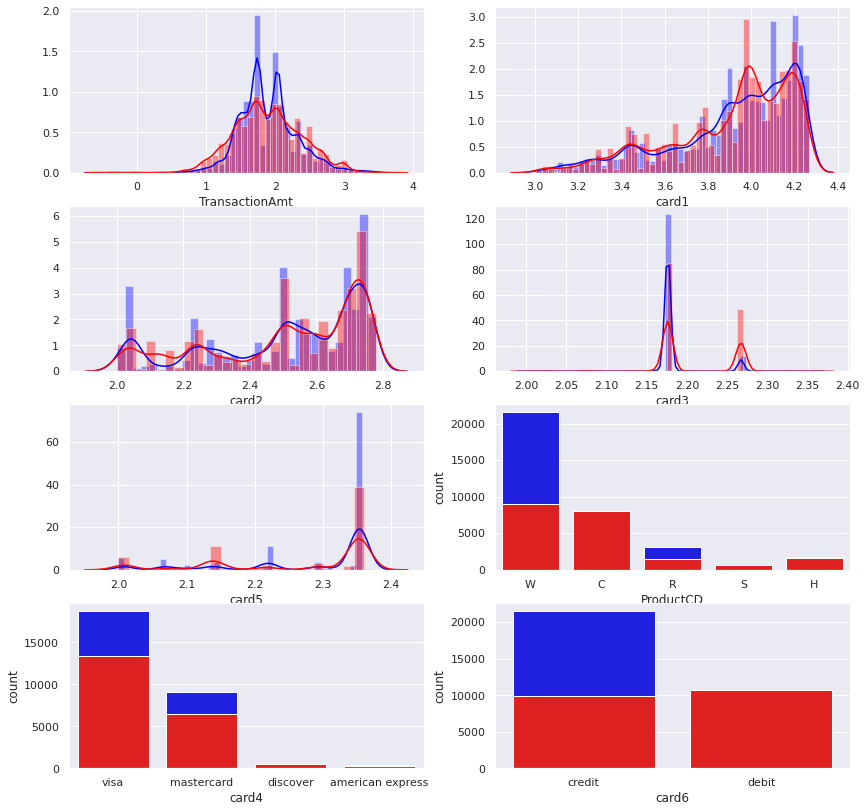

In [218]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,14))
sns.distplot(a=numpy.log10(X_neg['TransactionAmt']), ax=ax[0,0], color='blue')
sns.distplot(a=numpy.log10(X_pos['TransactionAmt']), ax=ax[0,0], color='red')
sns.distplot(a=numpy.log10(X_neg['card1']), ax=ax[0,1], color='blue')
sns.distplot(a=numpy.log10(X_pos['card1']), ax=ax[0,1], color='red')
sns.distplot(a=numpy.log10(X_neg['card2']), ax=ax[1,0], color='blue')
sns.distplot(a=numpy.log10(X_pos['card2']), ax=ax[1,0], color='red')
sns.distplot(a=numpy.log10(X_neg['card3']), ax=ax[1,1], color='blue')
sns.distplot(a=numpy.log10(X_pos['card3']), ax=ax[1,1], color='red')
sns.distplot(a=numpy.log10(X_neg['card5']), ax=ax[2,0], color='blue')
sns.distplot(a=numpy.log10(X_pos['card5']), ax=ax[2,0], color='red')
sns.countplot(x='ProductCD', data=X_neg, ax=ax[2,1], color='blue')
sns.countplot(x='ProductCD', data=X_pos, ax=ax[2,1], color='red')
sns.countplot(x='card4', data=X_neg, ax=ax[3,0], color='blue')
sns.countplot(x='card4', data=X_pos, ax=ax[3,0], color='red')
sns.countplot(x='card6', data=X_neg, ax=ax[3,1], color='blue')
sns.countplot(x='card6', data=X_pos, ax=ax[3,1], color='red')

In [219]:
X = pandas.concat([X_pos, X_neg]).reset_index(drop=True)
y = pandas.concat([y_pos, y_neg]).reset_index(drop=True)

In [220]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
0,445.000,W,18268,583.0,150.0,visa,226.0,credit
1,37.098,C,13413,103.0,185.0,visa,137.0,credit
2,37.098,C,13413,103.0,185.0,visa,137.0,credit
3,37.098,C,13413,103.0,185.0,visa,137.0,credit
4,155.521,C,16578,545.0,185.0,visa,226.0,credit


In [221]:
X_ = X.copy()

In [222]:
X_[['ProductCD', 'card4', 'card6']] = X[['ProductCD', 'card4', 'card6']].apply(LabelEncoder().fit_transform)

In [223]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
0,445.000,4,18268,583.0,150.0,3,226.0,0
1,37.098,0,13413,103.0,185.0,3,137.0,0
2,37.098,0,13413,103.0,185.0,3,137.0,0
3,37.098,0,13413,103.0,185.0,3,137.0,0
4,155.521,0,16578,545.0,185.0,3,226.0,0


In [224]:
X_ = MinMaxScaler().fit_transform(X_)

In [225]:
X_ = TSNE(n_components=2, n_jobs=JOBS).fit_transform(X_)

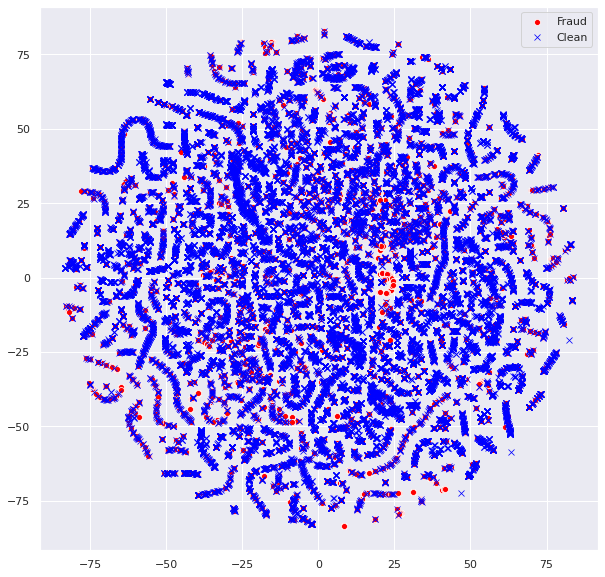

In [226]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_[0:X_pos.shape[0], 0], y=X_[0:X_pos.shape[0], 1], color='red', marker='o', label='Fraud')
sns.scatterplot(x=X_[X_pos.shape[0]:, 0], y=X_[X_pos.shape[0]:, 1], color='blue', marker='x', label='Clean')
plt.legend()

## Feature interaction

In [205]:
import hytests
from importlib import reload
reload(hytests)
from hytests import Hypot

tester = Hypot()
mapping = {'card1': 'cont', 'card2': 'cont', 'card3': 'cont', 'card5': 'cont', 'TransactionAmt': 'cont', 'card4': 'cat', 'card6': 'cat', 'ProductCD': 'cat'}

X_[['ProductCD', 'card4', 'card6']] = X[['ProductCD', 'card4', 'card6']].apply(LabelEncoder().fit_transform)
p = tester.test(data=X_, mapping=mapping)

In [215]:
p

,card1,card2,card3,card5,TransactionAmt,card4,card6,ProductCD
card1,1.00000,0.31550,0.00000,0.0,0.04078,0.0,0.0,0.0
card2,0.31550,1.00000,0.00001,0.0,0.00000,0.0,0.0,0.0
card3,0.00000,0.00001,1.00000,0.0,0.00000,0.0,0.0,0.0
card5,0.00000,0.00000,0.00000,1.0,0.00000,0.0,0.0,0.0
TransactionAmt,0.04078,0.00000,0.00000,0.0,1.00000,0.0,0.0,0.0
card4,0.00000,0.00000,0.00000,0.0,0.00000,1.0,0.0,0.0
card6,0.00000,0.00000,0.00000,0.0,0.00000,0.0,1.0,0.0
ProductCD,0.00000,0.00000,0.00000,0.0,0.00000,0.0,0.0,1.0


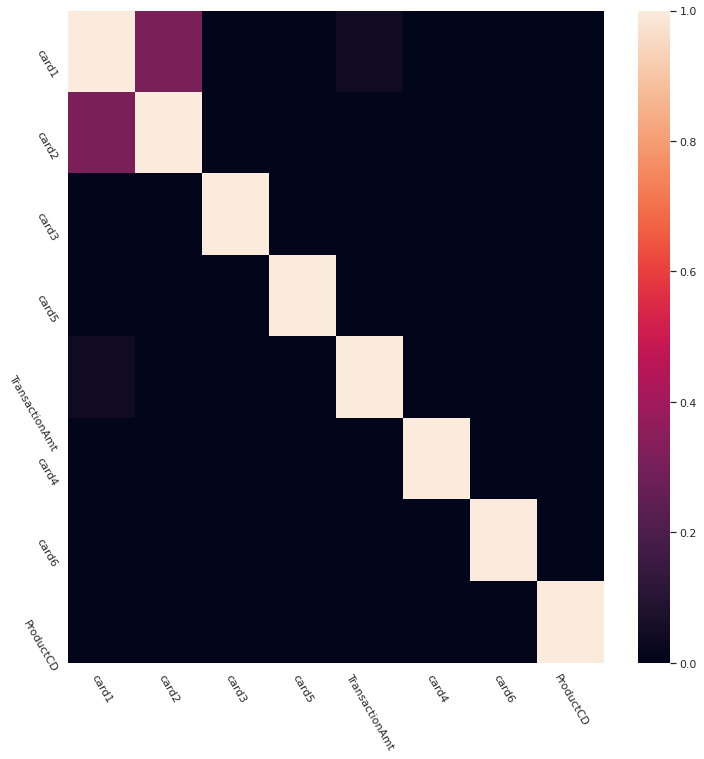

In [206]:
plt.figure(figsize=(12,12))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=300)
plt.xticks(rotation=300)
plt.show()

# Baseline Model

In [227]:
X_ = pandas.get_dummies(X, columns=['card4', 'card6', 'ProductCD'], drop_first=True)

In [228]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_debit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,445.000,18268,583.0,150.0,226.0,0,0,1,0,0,0,0,1
1,37.098,13413,103.0,185.0,137.0,0,0,1,0,0,0,0,0
2,37.098,13413,103.0,185.0,137.0,0,0,1,0,0,0,0,0
3,37.098,13413,103.0,185.0,137.0,0,0,1,0,0,0,0,0
4,155.521,16578,545.0,185.0,226.0,0,0,1,0,0,0,0,0


In [229]:
X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']]) 

In [230]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_debit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2.648360,4.261691,2.765669,2.176091,2.354108,0,0,1,0,0,0,0,1
1,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,0,0,0,0,0
2,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,0,0,0,0,0
3,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,0,0,0,0,0
4,2.191789,4.219532,2.736397,2.267172,2.354108,0,0,1,0,0,0,0,0


In [231]:
def ml_pipeline(X, y, n_splits, model):
    
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, )
    
    Output = recordtype('Output', ['precision', 'recall', 'f1', 'auc', 'aucs'])
    output = Output(precision=0, recall=0, f1=0, auc=0, aucs=[])
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    for train_index, test_index in cv.split(X, y):
    
        X_train, X_test, y_train, y_test = X[train_index, :], X[test_index, :], y[train_index], y[test_index]

        model.fit(X=X_train, y=y_train)
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1]
    
        recall = recall_score(y_true=y_test, y_pred=y_pred)
        precision = precision_score(y_true=y_test, y_pred=y_pred)
        f1 = f1_score(y_true=y_test, y_pred=y_pred)
        precisions, recalls, _ = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
        auc_ = auc(recalls, precisions)
        
        output.recall += recall
        output.precision += precision
        output.f1 += f1
        output.auc += auc_
        output.aucs.append(auc_)
        
        print(f'precision: {precision:0.4f}, recall: {recall:0.4f}, f1: {f1:0.4f}, auc: {auc_:0.4f}')
    
    output.recall /= n_splits
    output.precision /= n_splits
    output.f1 /= n_splits
    output.auc /= n_splits
    
    return output

In [ ]:
model = LogisticRegression(random_state=SEED, n_jobs=JOBS)
output_lr = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.6706, recall: 0.5269, f1: 0.5901, auc: 0.6781


# XGBoost

In [233]:
X_ = pandas.get_dummies(X, columns=['card4', 'card6', 'ProductCD'])

In [234]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']])

In [235]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2.648360,4.261691,2.765669,2.176091,2.354108,0,0,0,1,1,0,0,0,0,0,1
1,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,0,1,1,0,1,0,0,0,0
2,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,0,1,1,0,1,0,0,0,0
3,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,0,1,1,0,1,0,0,0,0
4,2.191789,4.219532,2.736397,2.267172,2.354108,0,0,0,1,1,0,1,0,0,0,0


In [236]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output_xgb = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.7655, recall: 0.6730, f1: 0.7163, auc: 0.8017
precision: 0.7514, recall: 0.6652, f1: 0.7057, auc: 0.7856
precision: 0.7673, recall: 0.6652, f1: 0.7126, auc: 0.8081
precision: 0.7577, recall: 0.6583, f1: 0.7045, auc: 0.7935
precision: 0.7639, recall: 0.6704, f1: 0.7141, auc: 0.7931
precision: 0.7492, recall: 0.6578, f1: 0.7005, auc: 0.7970
precision: 0.7630, recall: 0.6670, f1: 0.7118, auc: 0.8061
precision: 0.7576, recall: 0.6670, f1: 0.7094, auc: 0.7938
precision: 0.7716, recall: 0.6820, f1: 0.7240, auc: 0.8127
precision: 0.7711, recall: 0.6781, f1: 0.7216, auc: 0.8103


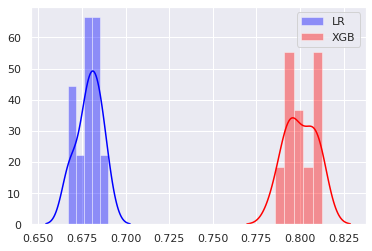

In [237]:
plt.figure()
sns.distplot(output_lr.aucs, color='blue', bins=5, label='LR')
sns.distplot(output_xgb.aucs, color='red', bins=5, label='XGB')
plt.legend()

In [238]:
ttest_rel(output_lr.aucs, output_xgb.aucs)

Ttest_relResult(statistic=-57.36225013499823, pvalue=7.488282697339015e-13)